In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

# Andiamo a costruire il modello LSTM

In [3]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [5]:
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
print(dataset.shape)
dataset.head()

(3020, 6)


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [5]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

<class 'pandas.core.series.Series'>


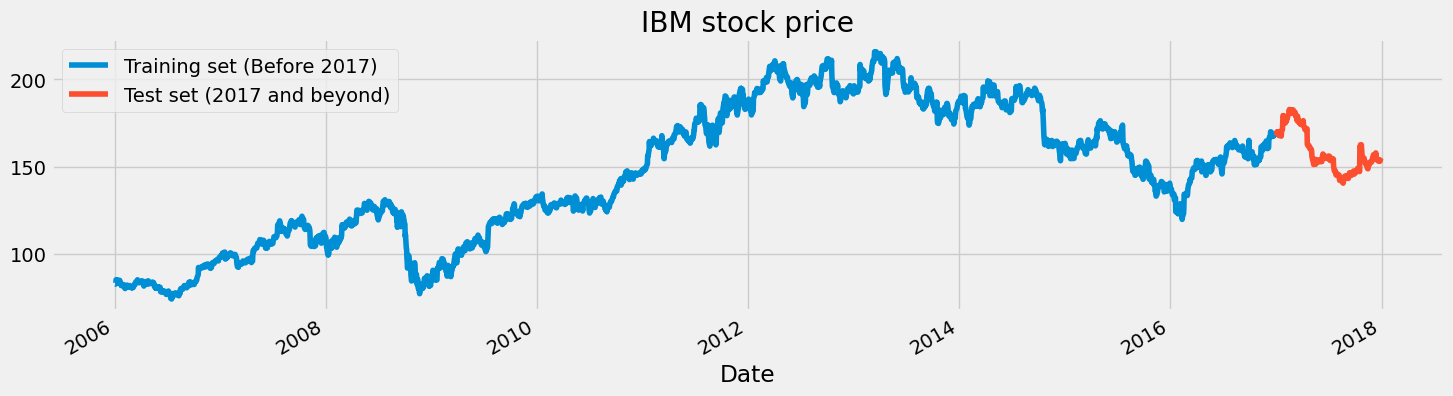

In [6]:
print(type(dataset["High"][:'2016']))
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [10]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
    '''print(training_set_scaled[i-60:i,0])
    print(training_set_scaled[i,0])'''
X_train, y_train = np.array(X_train), np.array(y_train)

In [35]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
print(y_train.shape)

(2709, 60, 1)
(2709,)


In [13]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

In [14]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 13s 72ms/step - loss: 0.0233
Epoch 2/50
85/85 [==============================] - 12s 143ms/step - loss: 0.0110
Epoch 3/50
85/85 [==============================] - 19s 228ms/step - loss: 0.0081
Epoch 4/50
85/85 [==============================] - 19s 227ms/step - loss: 0.0072
Epoch 5/50
85/85 [==============================] - 19s 226ms/step - loss: 0.0065
Epoch 6/50
85/85 [==============================] - 19s 226ms/step - loss: 0.0054
Epoch 7/50
85/85 [==============================] - 19s 226ms/step - loss: 0.0053
Epoch 8/50
85/85 [==============================] - 19s 223ms/step - loss: 0.0044
Epoch 9/50
85/85 [==============================] - 19s 221ms/step - loss: 0.0042
Epoch 10/50
85/85 [==============================] - 8s 93ms/step - loss: 0.0037
Epoch 11/50
85/85 [==============================] - 17s 202ms/step - loss: 0.0038
Epoch 12/50
85/85 [==============================] - 19s 225ms/step - loss: 0.0037
Epoch 13/50
85/8

In [16]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [17]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 2s 25ms/step


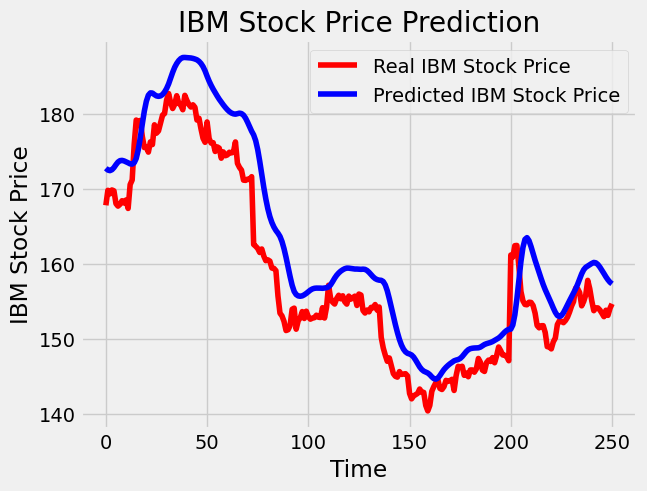

In [18]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [19]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 5.46282797835398.


# Andiamo a costruire il modello GRU

In [20]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


c:\Users\pc\anaconda3\envs\agrivision\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - 19s 517ms/step - loss: 0.1582
Epoch 2/50
19/19 [==============================] - 10s 525ms/step - loss: 0.0374
Epoch 3/50
19/19 [==============================] - 4s 201ms/step - loss: 0.0068
Epoch 4/50
19/19 [==============================] - 6s 317ms/step - loss: 0.0042
Epoch 5/50
19/19 [==============================] - 10s 521ms/step - loss: 0.0037
Epoch 6/50
19/19 [==============================] - 10s 516ms/step - loss: 0.0034
Epoch 7/50
19/19 [==============================] - 10s 545ms/step - loss: 0.0032
Epoch 8/50
19/19 [==============================] - 10s 550ms/step - loss: 0.0030
Epoch 9/50
19/19 [==============================] - 9s 489ms/step - loss: 0.0031
Epoch 10/50
19/19 [==============================] - 9s 485ms/step - loss: 0.0028
Epoch 11/50
19/19 [==============================] - 9s 497ms/step - loss: 0.0029
Epoch 12/50
19/19 [==============================] - 10s 504ms/step - loss: 0.0029
Epoch 13/50
19/19 [==========

In [21]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 [==============================] - 4s 25ms/step


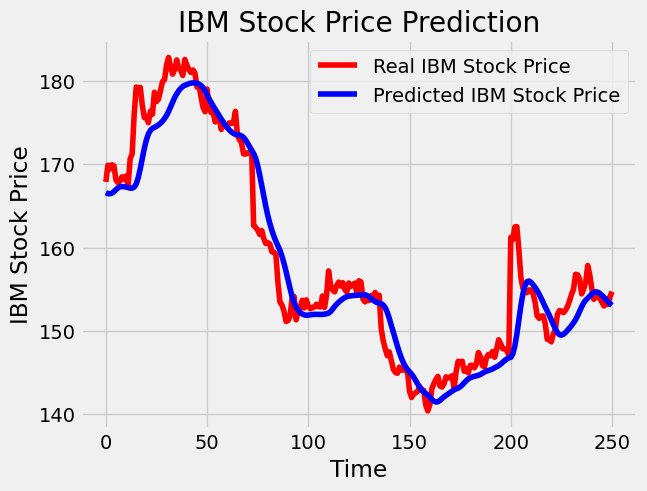

In [22]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [23]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.444608257253095.
